<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform - Corine land cover change over an alpine region

## Objectives and approach

The objective of this notebook is to show a sample usage of the Corine Land Cover collection

Please check that the installed openeo library is up to date (>=0.10.0)

In [1]:
import openeo
openeo.client_version()

'0.10.1'

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

### Connect and authenticate to openEO Platform

In [3]:
connection = openeo.connect('openeo.cloud')
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

#### Have a look at the `corine_land_cover` collection

In [4]:
connection.describe_collection('corine_land_cover')

{'cube:dimensions': {'bands': {'type': 'bands', 'values': ['CLC']},
  't': {'extent': [['2000-12-15T00:00:00', '2018-12-15T00:00:00']],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [1400000.0, 7900000.0],
   'reference_system': 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [100000.0, 4500000.0],
   'reference_system': 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
   'type': 'spatial'}},
 'description': 'The CORINE Land Cover (CLC) inventory began in 1985, consisting of 44 land cover classes. This collection is resampled and stored at a 10m x 10m resolution. For further information on CORINE land cover see [here](https://land.copernicus.eu/pan-european/corine-land-cover)',
 'extent': {'spatial': {'bbox': [[-32.091997820189285,
     31.6977150076753,
     55.116146716432254,
     72.11413813793037]]},
  'temporal': {'interval': [['2000-12-15T00:00:00Z',
     '2018-12-15T00:00:00Z']]}},
 'id': 'corine_land_cover',
 'item_assets': {},
 'keywords': ['EODC', 'Copernicus', 'ARD', 'Level-3'],
 'license': 'proprietary',
 'links': [{'href': 'https://openeo.eodc.eu/v1.0', 'rel': 'root'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'parent'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections/corine_land_cover',
   'rel': 'self'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections/corine_land_cover/items',
   'rel': 'items'}],
 'properties': {},
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.0.0/schema.json',
  'https://stac-extensions.github.io/item-assets/v1.0.0/schema.json',
  'https://github.com/stac-extensions/eo'],
 'stac_version': '1.0.0',
 'summaries': {'constellation': {},
  'eo:bands': [{'common_name': 'band1', 'name': 'CLC'}],
  'odc:file_format': {'0': 'GeoTIFF'},
  'odc:product_family': {'0': 'level2'},
  'platform': {}},
 'title': 'CORINE Land Cover',
 'type': 'Collection'}

<img src="./CorineLandClasses.png"
     width=500px
     alt="CLC" />

### Area of Interest

Predefined area of interest:

In [5]:
spatial_extent = {'west': 12.527161, 'south': 47.00008, 'east': 12.897949, 'north': 47.254223}

If you would like to use a different AOI, uncomment and run the next cell, click on the rectangle button and then draw the area over the map

In [6]:
# from eo_utils import openeoMap
# center = [47, 12.84]
# zoom = 11

# eoMap = openeoMap(center,zoom)
# eoMap.map

Get the spatial extent of the selected area in the map

In [7]:
# from openeo.util import to_bbox_dict
# bbox = eoMap.getBbox()
# spatial_extent = to_bbox_dict(bbox) 
# print(spatial_extent)

### Load the dataset

Load the Corine Land Cover collection. It contains a single band called CLC.

In [8]:
collection = 'corine_land_cover'
corine_data = connection.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=['2000-01-01', '2019-04-30'],
    bands=['CLC'], 
)

The land cover class 34 is "Glaciers and perpetual snow".

Look at where the data is equal to 34

In [9]:
corine_eq_34 = corine_data == 34

Use the filter_temporal process to get the data of the years 2000 and 2018:

In [10]:
corine_2000 = corine_eq_34.filter_temporal(extent=['2000-01-01', '2001-01-01'])
corine_2018 = corine_eq_34.filter_temporal(extent=['2018-01-01', '2019-01-01'])

Merge the data into a single datacube:

In [11]:
corine_merged = corine_2000.merge_cubes(corine_2018)

Save the result as a netCDF file:

In [12]:
corine_merged_saved = corine_merged.save_result('NetCDF')

Everything that has been done until now, didn't process any data. We have just created a description of the pipeline we want to run as a JSON text file, which will be sent to the back-end and processed later.

The current openEO process has the following content:

In [13]:
corine_merged_saved.flat_graph()

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['CLC'],
   'id': 'corine_land_cover',
   'spatial_extent': {'west': 12.527161,
    'south': 47.00008,
    'east': 12.897949,
    'north': 47.254223},
   'temporal_extent': ['2000-01-01', '2019-04-30']}},
 'apply1': {'process_id': 'apply',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'process': {'process_graph': {'eq1': {'process_id': 'eq',
      'arguments': {'x': {'from_parameter': 'x'}, 'y': 34},
      'result': True}}}}},
 'filtertemporal1': {'process_id': 'filter_temporal',
  'arguments': {'data': {'from_node': 'apply1'},
   'extent': ['2000-01-01', '2001-01-01']}},
 'filtertemporal2': {'process_id': 'filter_temporal',
  'arguments': {'data': {'from_node': 'apply1'},
   'extent': ['2018-01-01', '2019-01-01']}},
 'mergecubes1': {'process_id': 'merge_cubes',
  'arguments': {'cube1': {'from_node': 'filtertemporal1'},
   'cube2': {'from_node': 'filtertemporal2'}}},
 'saveresult1': {'process_

Now we can actually create a batch job:

In [44]:
job = corine_merged_saved.create_job(title = 'CORINE_LAND_COVER')

In [45]:
job

<RESTJob job_id='eodc-jb-55ab4713-fc49-4c88-89dd-4f6c79e2a64a'>

And start the batch job:

In [46]:
job.start_job()

Please run the next cell after some time and check the job status. Once it is 'finished', you can proceed.

In [61]:
print(f'Batch job with id {job.job_id} has status  {job.status()}')

Batch job with id eodc-jb-55ab4713-fc49-4c88-89dd-4f6c79e2a64a has status  finished


Otherwise, you can also show all your jobs and their status:

In [ ]:
connection.list_jobs()

If you need to recover the job after a python kernel reset, you can do it by:

In [34]:
# job_id = 'eodc-jb-61201a6c-0d8a-44f2-b9e5-2a1cbab39056' #You would have to modify this
# job = connection.job(job_id)

Now that the job has been completed, we can download the results:

In [ ]:
results = job.get_results()
results

In [63]:
metadata = results.get_metadata()
results.download_files('./demo_data/')

[PosixPath('demo_data/out_2000_12_15T00_00_00_EU010M_E049N015T1'),
 PosixPath('demo_data/out_2018_12_15T00_00_00_EU010M_E049N015T1'),
 PosixPath('demo_data/job-results.json')]

In [3]:
result_files_2000 = sorted(glob('./demo_data/out_2000*'))
result_files_2018 = sorted(glob('./demo_data/out_2018*'))

In [4]:
CLC_2000 = xr.open_dataset(result_files_2000[0])
CLC_2018 = xr.open_dataset(result_files_2018[0])
CLC_2018

<xarray.Dataset>
Dimensions:      (y: 3233, x: 3208)
Coordinates:
    t            datetime64[ns] ...
  * y            (y) float64 1.55e+06 1.55e+06 1.55e+06 ... 1.518e+06 1.518e+06
  * x            (x) float64 4.967e+06 4.967e+06 ... 4.999e+06 4.999e+06
    spatial_ref  int32 ...
Data variables:
    CLC          (y, x) float64 ...
Attributes:
    crs:                PROJCRS["Azimuthal_Equidistant",BASEGEOGCRS["WGS 84",...
    nodata:             -9999
    collection:         corine_land_cover
    datetime_from_dim:  2022-06-28 12:35:23.153652

In [5]:
CLC_2000 = CLC_2000.CLC.values
CLC_2018 = CLC_2018.CLC.values

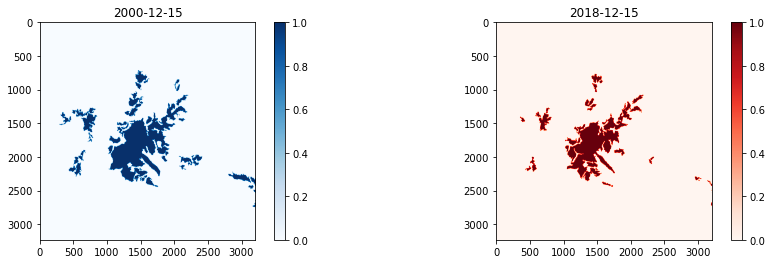

In [6]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.title('2000-12-15')
plt.imshow(CLC_2000, cmap = 'Blues')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('2018-12-15')
plt.imshow(CLC_2018, cmap = 'Reds')
plt.colorbar()

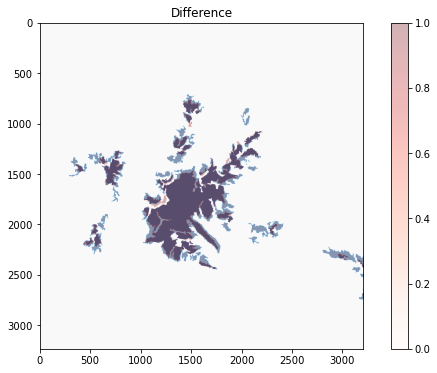

In [7]:
plt.figure(figsize=(10,6))
plt.title('Difference')
plt.imshow(CLC_2000, cmap='Blues', alpha=0.7)
plt.imshow(CLC_2018, cmap='Reds', alpha=0.3)
plt.colorbar()

Count the Glaciers and perpetual snow pixels.

In [8]:
counts00 = np.sum(CLC_2000)
counts18 = np.sum(CLC_2018)

In [9]:
class_table = pd.DataFrame({'year': [2000, 2018], 'Glaciers and perpetual snow': [counts00, counts18]})
class_table

,year,Glaciers and perpetual snow
0,2000,783106.0
1,2018,509432.0


In [30]:
diff[~np.isnan(diff)] = 1

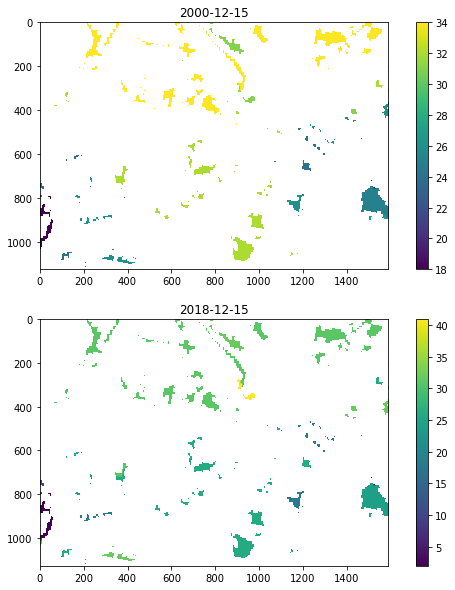

In [31]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('white')
plt.subplot(2,1,1)
plt.title("2000-12-15")
plt.imshow(corine_2000*diff)   
plt.colorbar()

plt.subplot(2,1,2)
plt.title("2018-12-15")
plt.imshow(corine_2018*diff)   
plt.colorbar()


Which classes are there? 

In [32]:
numbers = [2, 7, 11, 18, 20, 21, 23, 24, 25, 26, 27, 29, 31, 32, 34, 41]
classes = ["Discontinuous urban fabric", "Mineral extraction sites", "Sport and leisure facilities", "Pastures", "Complex cultivation patterns", "Land principally occupied by agriculture with significant areas of natural vegetation", "Broad-leaved forest", "Coniferous forest", "Mixed forest", "Natural grasslands", "Moors and heathland", "Transitional woodland-shrub", "Bare rocks", "Sparsely vegetated areas", "Glaciers and perpetual snow", "Water bodies"]
class_table = pd.DataFrame({'number': numbers, 'class': classes}).set_index('number')
(unique00, counts00) = np.unique(corine_2000*diff, return_counts=True)
(unique18, counts18) = np.unique(corine_2018*diff, return_counts=True)
table_2000 = pd.DataFrame({'number': unique00.astype("int64"), 'counts_2000': counts00}).set_index('number')
table_2018 = pd.DataFrame({'number': unique18.astype("int64"), 'counts_2018': counts18}).set_index('number')

In [33]:
result = pd.concat([class_table, table_2000, table_2018], axis=1)
result

,class,counts_2000,counts_2018
number,,,
2,Discontinuous urban fabric,NaN,6985.0
7,Mineral extraction sites,NaN,NaN
11,Sport and leisure facilities,NaN,1190.0
18,Pastures,7301.0,15030.0
20,Complex cultivation patterns,NaN,NaN
21,Land principally occupied by agriculture with ...,NaN,NaN
23,Broad-leaved forest,NaN,NaN
24,Coniferous forest,15320.0,16911.0
25,Mixed forest,13013.0,NaN


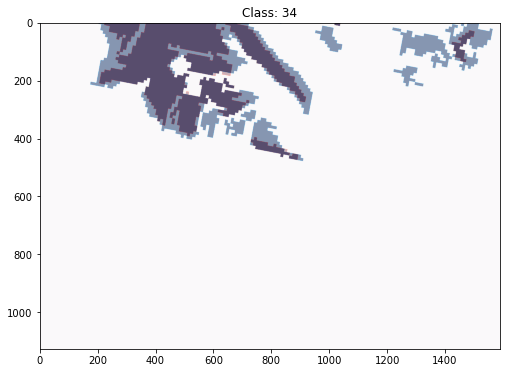

In [34]:
clc = 34
mask = np.ones(corine_2000.shape)
mask[corine_2000 != clc] = 0
mask2 = np.ones(corine_2018.shape)
mask2[corine_2018 != clc] = 0
fig = plt.figure(figsize=(12,6))
fig.patch.set_facecolor('white')
plt.title(f"Class: {clc}")
plt.imshow(corine_2000*mask, cmap="Blues", alpha=0.7)
plt.imshow(corine_2018*mask2, cmap="Reds", alpha=0.3)
